In [1]:
# # install libraries/packages/modules 
# !pip install opencv-python
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install timm

# Understand Facial Keypoint Dataset 

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


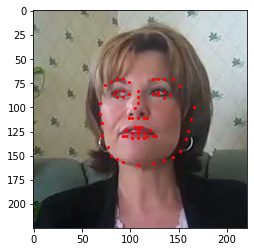

In [4]:
idx = 23

img_name = train_df['Unnamed: 0'].iloc[idx]
img = cv2.imread(TRAIN_IMG_DIR+img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

key = train_df.iloc[idx][1:].to_numpy().reshape(-1,2) #(136,) -> (68,2)
plt.imshow(img)
plt.scatter(key[:,0],key[:,1], s = 4, c = 'r')

In [5]:
train_df, valid_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

# Create Custom Facial Keypoint Dataset

In [6]:
import albumentations as A 

In [7]:
class FacialKeyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, img_data_dir, augmentations = None):
        
        self.df = df
        self.img_data_dir = img_data_dir
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img_name = self.df['Unnamed: 0'].iloc[idx]
        img = cv2.imread(self.img_data_dir + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        key = self.df.iloc[idx][1:].to_numpy().reshape(-1,2)
        
        if self.augmentations != None:
            augmentated_data = self.augmentations(image = img, keypoints = key)
            img = torch.from_numpy(augmentated_data['image']).float()
            key = torch.tensor(augmentated_data['keypoints']).float()
            
        return img.permute(2,0,1),key.view(-1)

In [8]:
train_augs = A.Compose([
    A.Resize(H_IMG_SIZE, W_IMG_SIZE),
    A.Normalize(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


valid_augs = A.Compose([
    A.Resize(H_IMG_SIZE, W_IMG_SIZE),
    A.Normalize()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [9]:
trainset = FacialKeyDataset(train_df, TRAIN_IMG_DIR, train_augs)
validset = FacialKeyDataset(valid_df, TRAIN_IMG_DIR, valid_augs)
testset = FacialKeyDataset(test_df, TEST_IMG_DIR, valid_augs)

In [10]:
print("Total no. of examples present in trainset : {}".format(len(trainset)))
print("Total no. of examples present in validset : {}".format(len(validset)))

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


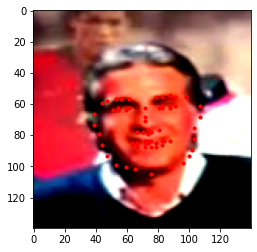

In [11]:
img, key = trainset[23]
imshow_with_key(img, key)

# Load Dataset into Batches 

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = False)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [14]:
for data in trainloader:
    image, key = data
    break;
    
print("Shape of one batch image : {}".format(image.shape))
print("Shape of one batch key : {}".format(key.shape))

Shape of one batch image : torch.Size([16, 3, 140, 140])
Shape of one batch key : torch.Size([16, 136])


# Create Model 

In [15]:
import timm

In [16]:
class FacialKeyModel(torch.nn.Module):
    
    def __init__(self, model_name = MODEL_NAME):
        super(FacialKeyModel, self).__init__()
        
        print("Loading Backbone : {}".format(model_name))
        self.backbone = timm.create_model(model_name, pretrained = True, num_classes = OUTPUT_SIZE)
        
    def forward(self,images, key = None):
        
        out_key = self.backbone(images)
        
        if key != None:
            return out_key, torch.nn.MSELoss()(out_key, key)
        
        return out_key

In [17]:
model = FacialKeyModel()
model.to(DEVICE);

Loading Backbone : resnet18


# Trainer and Evaluator

In [18]:
def train_fn(trainloader, model, optimizer):
    # loop over the dataset multiple times
    model.train()
    
    running_loss = 0.0
    for data in tqdm(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, loss = model(inputs, labels)
        # loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    return running_loss/len(trainloader)

In [19]:
def eval_fn(evalloader, model):
    # loop over the dataset multiple times
    model.eval()
    eval_loss = 0
    for data in tqdm(evalloader):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            outputs, loss = model(inputs, labels)
        
        eval_loss += loss.item()

    return eval_loss/len(evalloader)

# Training model 

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    eval_loss = eval_fn(validloader, model)

    torch.save(model.state_dict(), f"{MODEL_PATH}/{MODEL_NAME}_ft_epoch{i}.model")
    print(f"Epoch: {i}, Train_loss: {train_loss}, Valid_loss: {eval_loss}")



  0%|          | 0/174 [00:00<?, ?it/s]

C:\Users\uber\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 0, Train_loss: 1249.1840088285248, Valid_loss: 115.69232004339045


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 1, Train_loss: 41.323412665005385, Valid_loss: 39.563967357982285


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 2, Train_loss: 36.446384155887294, Valid_loss: 32.37515024705367


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 3, Train_loss: 23.297205267281367, Valid_loss: 22.47560522773049


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 4, Train_loss: 20.060217177730866, Valid_loss: 17.70277138189836


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 5, Train_loss: 17.47598595454775, Valid_loss: 16.405204361135308


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 6, Train_loss: 15.809391402650153, Valid_loss: 15.409423741427334


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 7, Train_loss: 14.488965516802908, Valid_loss: 14.31743277202953


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 8, Train_loss: 13.306530261861868, Valid_loss: 14.397277225147594


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 9, Train_loss: 11.07950193854584, Valid_loss: 9.96644874052568


# Visualizing Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


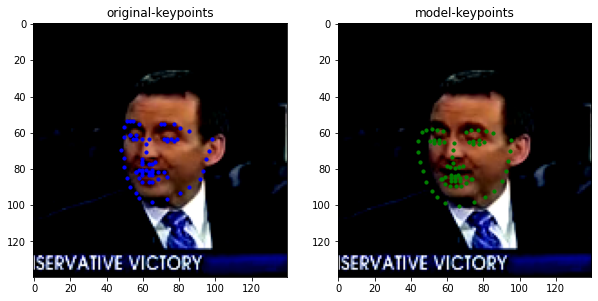

In [23]:
index = 9
image, key = testset[index]

model.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_NAME}_ft_epoch{EPOCHS-1}.model", map_location = DEVICE))
model.eval()
with torch.no_grad():
    image = image.to(DEVICE)
    out_key = model(image.unsqueeze(0))
    compare_keypoints(image, key, out_key)